# **USED CAR PRICE PREDICTION**

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Download file for plotting complexity curves

In [1]:
!curl https://raw.githubusercontent.com/francescopisu/Used-car-price-prediction/master/curves.py --output curves.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3760  100  3760    0     0  21485      0 --:--:-- --:--:-- --:--:-- 21485
CPU times: user 23 ms, sys: 8.46 ms, total: 31.5 ms
Wall time: 2.79 s


### Downlod dataset

In [2]:
# May take up to 5 minutes depending on connection
!curl https://raw.githubusercontent.com/francescopisu/Used-car-price-prediction/master/data/cars.csv --output cars.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86.2M  100 86.2M    0     0  78.5M      0  0:00:01  0:00:01 --:--:-- 78.5M


In [3]:
!pip install spark-sklearn
!pip install pyspark

In [4]:
pip install rfpimp

**IMPORTING LIBRARIES**

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np
import datetime
import matplotlib
import numpy as np
import pickle
import matplotlib.pyplot as plt
import curves
from sklearn import preprocessing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, Normalizer
from spark_sklearn import GridSearchCV
from spark_sklearn.util import createLocalSparkSession
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


**READ THE CSV INPUT FILE**

In [0]:
# Read data
cars = pd.read_csv('cars.csv', encoding='latin1', error_bad_lines=False, warn_bad_lines=False)

In [0]:
cars.sample(5)

,Id,Price,Year,Mileage,City,State,Vin,Make,Model
1129394,1144523,10990,2012,88999,Miamisburg,OH,4T4BF1FK7CR169064,Toyota,CamryLE
676859,682226,23898,2014,32958,Charlotte,NC,2FMHK6C8XEBD33938,Ford,FlexSEL
1191760,1208548,14100,2015,31262,Sanford,FL,1VWBT7A32FC030316,Volkswagen,Passat4dr
811830,817197,15000,2016,12023,Springfield,VA,KMHD35LH7GU302651,Hyundai,Elantra
1203284,1220072,20000,2015,16506,Rockaway,NJ,WVGBV7AX4FW079303,Volkswagen,TiguanS


In [0]:
cars.columns

Index(['Id', 'Price', 'Year', 'Mileage', 'City', 'State', 'Vin', 'Make',
       'Model'],
      dtype='object')

## ANALYSING PRICE ATTRIBUTE

In [0]:
cars['Price'].describe()

count    1.104141e+06
mean     2.087280e+04
std      1.179084e+04
min      1.500000e+03
25%      1.340000e+04
50%      1.799800e+04
75%      2.599500e+04
max      3.999880e+05
Name: Price, dtype: float64

Skewness: 4.154836
Kurtosis: 60.754628


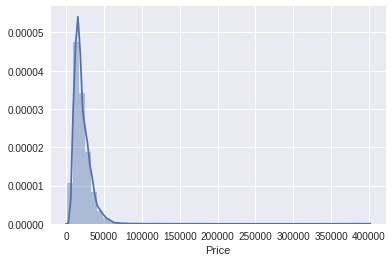

In [0]:
sns.distplot(cars['Price'])
#skewness and kurtosis
print("Skewness: %f" % cars['Price'].skew())
print("Kurtosis: %f" % cars['Price'].kurt())

"""
We can observe that the distribution of prices shows a high positive skewness 
to the left (skew > 1). A kurtosis value of 60 is extremely high, meaning that
there is a profusion of outliers in the dataset. We need to do something.
"""

### RELATIONSHIP WITH NUMERICAL FEATURES

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


"\nWe see that the lesser is the mileage, the higher tends to be the price. \nPrice and Mileage seem to be in an exponential relationship with negative\nexponent. It's a typical form of exponential decay.\n"

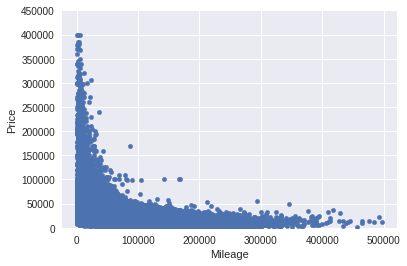

In [0]:
# Scatter plot Mileage / Price
attrib = 'Mileage'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
data.plot.scatter(x=attrib, y='Price', ylim=(0,450000));

"""
We see that the lesser is the mileage, the higher tends to be the price. 
Price and Mileage seem to be in an exponential relationship with negative
exponent. It's a typical form of exponential decay.
"""

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


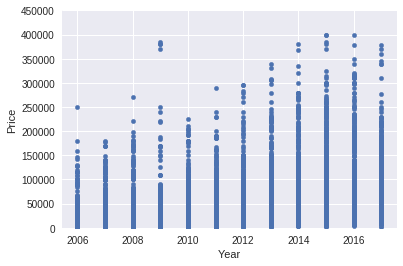

In [0]:
# Scatter plot Year / Price
attrib = 'Year'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
data.plot.scatter(x=attrib, y='Price', ylim=(0,450000));

"""
Prices tend to be higher as cars are more recent, and viceversa.
"""

### RELATIONSHIP WITH CATEGORICAL FEATURES

'\nWe can observe there is a correlation between Price and Exotic/Luxury car manufacturers.\nOn a sidenote, there is a prevalence of low to medium budget cars in the dataset\n\nSeveral car manufacturers as Porsche, Audi, Chevreolet ecc.. have a strong \npresence of outliers, altought outliers may not be the right term because\nthose makers produce car models that cost more than others.\n'

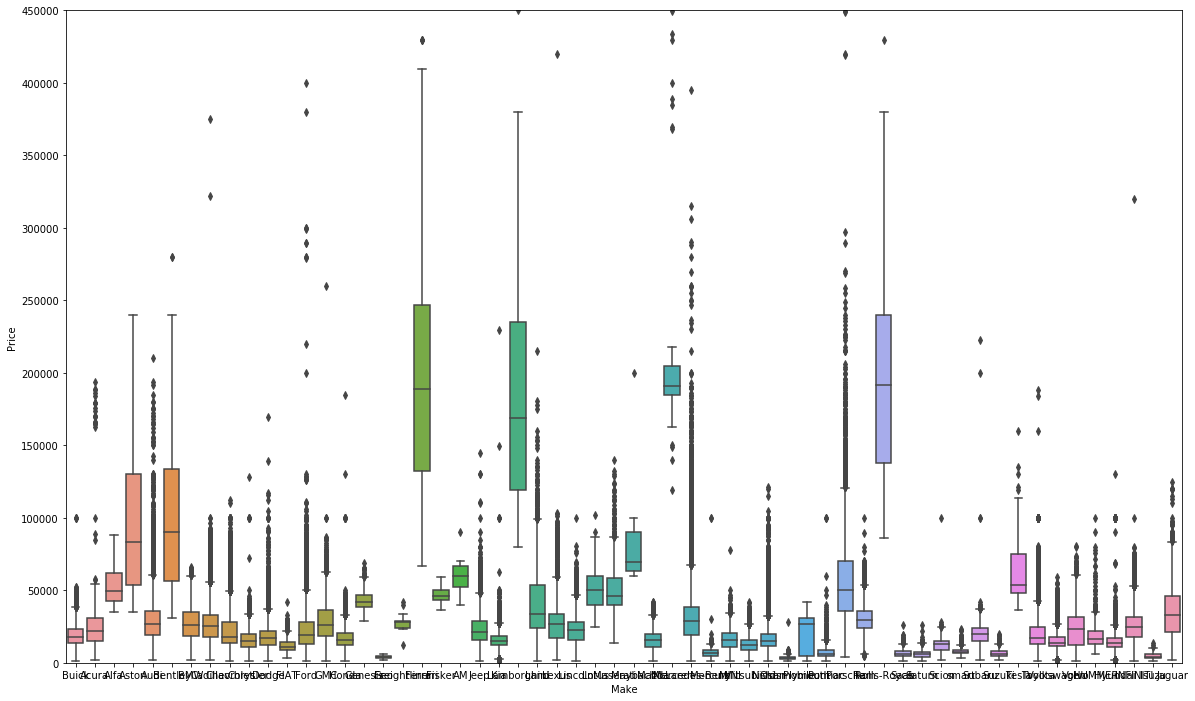

In [7]:
# Box plot Make (Car manufacturers) / Price

attrib = 'Make'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x=attrib, y="Price", data=data)
fig.axis(ymin=0, ymax=450000);

"""
We can observe there is a correlation between Price and Exotic/Luxury car manufacturers.
On a sidenote, there is a prevalence of low to medium budget cars in the dataset

Several car manufacturers as Porsche, Audi, Chevreolet ecc.. have a strong 
presence of outliers, altought outliers may not be the right term because
those makers produce car models that cost more than others.
"""

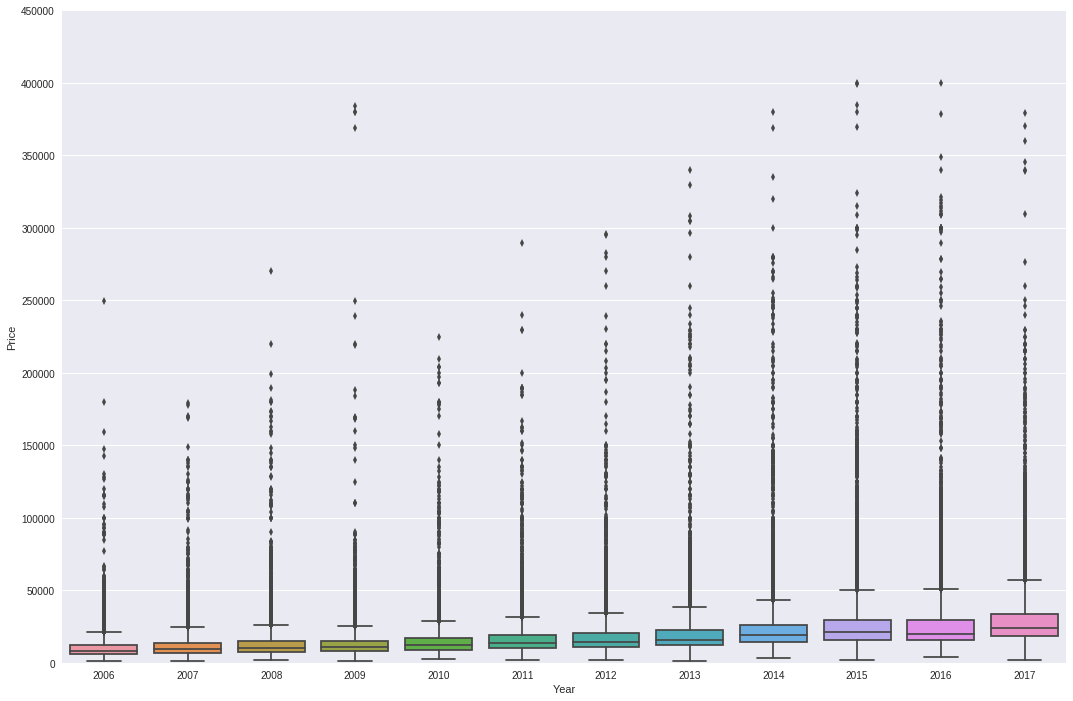

In [0]:
# Box plot Year / Price

attrib = 'Year'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
f, ax = plt.subplots(figsize=(18, 12))
fig = sns.boxplot(x=attrib, y="Price", data=data)
fig.axis(ymin=0, ymax=450000);

"""
We can observe a slight increase of Prices the most recent years. Not a strong
tendency though.
"""

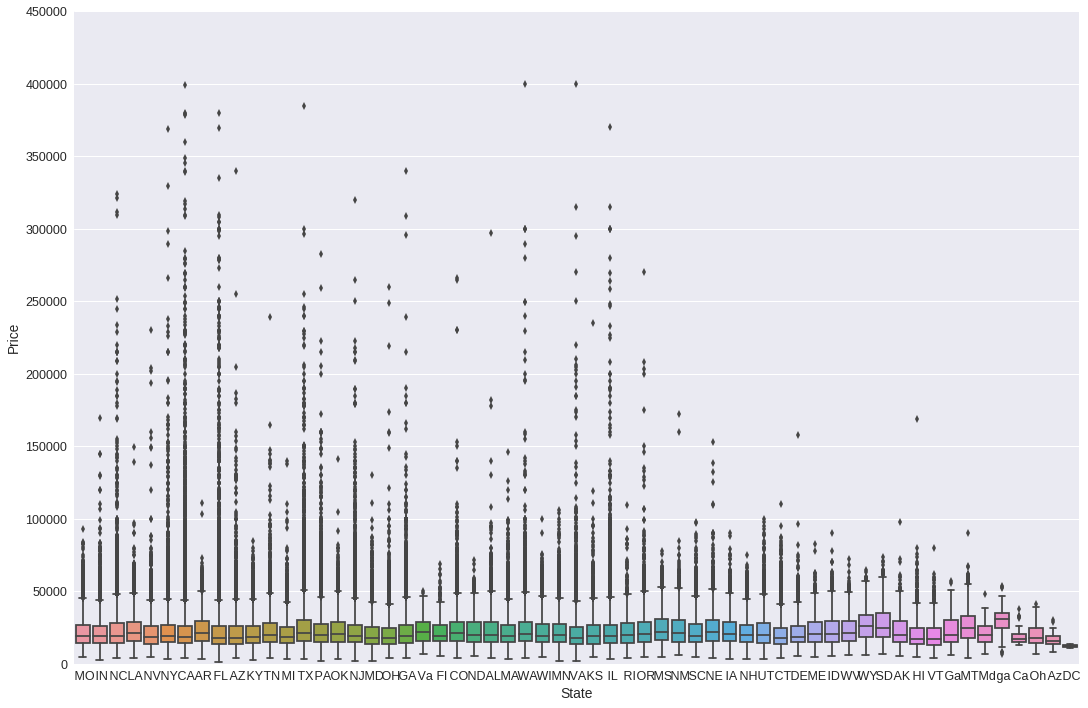

In [0]:
# Box plot State / Price

attrib = 'State'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
f, ax = plt.subplots(figsize=(18, 12))
fig = sns.boxplot(x=attrib, y="Price", data=data)
fig.axis(ymin=0, ymax=450000);

### FEATURE IMPORTANCE RELATED TO TARGET


In [0]:
# Find most important features relative to target Price
print("Find most important features relative to target")
corr = cars.corr()
corr.sort_values(["Price"], ascending = False, inplace = True)
print(corr.Price)

"""
Between Year and Price there is a positive correlation, meaning that the higher
is the Year (more recent), the higher is the Price (more recent cars cost more).
Between Price and Mileage there is a negative correlation, meaning that higher
is the mileage, lower is the Price (cars with high mileage cost less).

We obviously will get rid of Id attribute.
"""

Find most important features relative to target
Price      1.000000
Year       0.384824
Id        -0.022876
Mileage   -0.405779
Name: Price, dtype: float64


### CORRELATION MATRIX

'\nThere is a mild positive correlation between Year and Price and a mild\nnegative correlation between Year and Mileage (as we have already said).\nMoreover the is a strong negative correlation between Mileage and Year,\nmeaning that the older is the car, the higher will be its mileage.\nObviously there are exceptions but that is the general trend.\n'

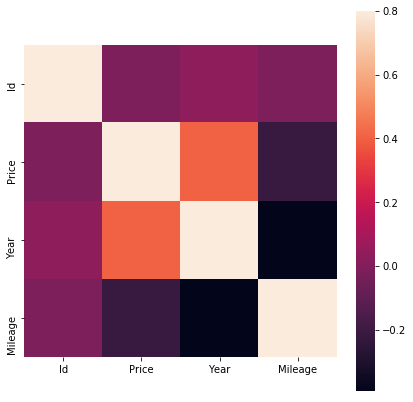

In [0]:
# General correlation matrix
corrmat = cars.corr()
f, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(corrmat, vmax=.8, square=True);

"""
There is a mild positive correlation between Year and Price and a mild
negative correlation between Year and Mileage (as we have already said).
Moreover the is a strong negative correlation between Mileage and Year,
meaning that the older is the car, the higher will be its mileage.
Obviously there are exceptions but that is the general trend.
"""

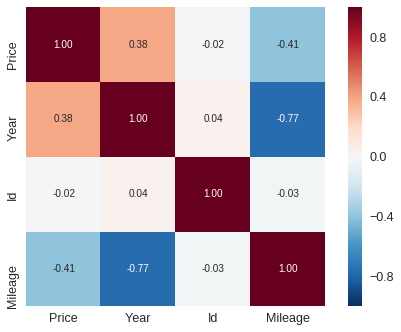

In [0]:
# Price correlation matrix
k = 4 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Price')['Price'].index
cm = np.corrcoef(cars[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

"""
This plot shows what we said earies but in form of numbers.
"""

### SCATTERPLOTS

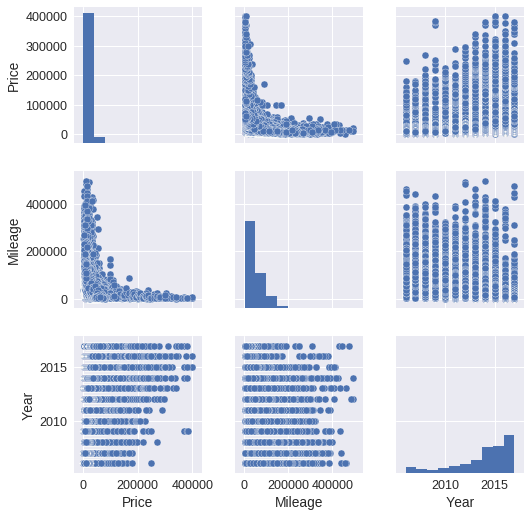

In [0]:
# Scatter plot for numerical features
num_features = ["Price", "Mileage", "Year"]
sns.pairplot(cars[num_features], size = 2.5)
plt.show();

## **PREPROCESSING**

In [0]:
# Checking for missing values -> no missing values
cars.isnull().sum()

Id         0
Price      0
Year       0
Mileage    0
City       0
State      0
Vin        0
Make       0
Model      0
dtype: int64

In [0]:
# Checking for plausible values of numerical features -> we can see that the maximum value of mileage is 77milion km
# we need to fix these problems
cars.describe()

,Id,Price,Year,Mileage
count,1.216250e+06,1.216250e+06,1.216250e+06,1.216250e+06
mean,6.132814e+05,2.096887e+04,2.013307e+03,5.290810e+04
std,3.546571e+05,1.315940e+04,3.441842e+00,8.192775e+04
min,1.000000e+00,1.500000e+03,1.997000e+03,5.000000e+00
25%,3.081122e+05,1.299400e+04,2.012000e+03,2.396200e+04
50%,6.134915e+05,1.799500e+04,2.014000e+03,4.053400e+04
75%,9.175538e+05,2.641400e+04,2.016000e+03,7.272500e+04
max,1.233042e+06,4.995000e+05,2.018000e+03,7.758776e+07


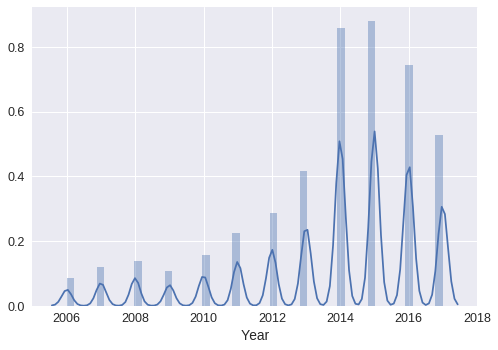

In [0]:
# Record distribution over the year
sns.distplot((cars["Year"]))

In [0]:
# Checking values of categorical features
cat_val = ["City", "State", "Vin", "Make","Model"]
for col in cat_val:
    print ([col]," : ",cars[col].unique())
    
# Features like Id, State and Vin can be discarded because wouldn't bring anything good to our purpose

['City']  :  ['Jefferson City' 'Highland' 'Boone' ... 'Northfield' 'Huntington Valley'
 'Winslow']
['State']  :  [' MO' ' IN' ' NC' ' LA' ' NV' ' NY' ' CA' ' AR' ' FL' ' AZ' ' KY' ' TN'
 ' MI' ' TX' ' PA' ' OK' ' NJ' ' MD' ' OH' ' GA' ' Va' ' Fl' ' CO' ' ND'
 ' AL' ' IL' ' MA' ' WA' ' WI' ' MN' ' VA' ' KS' ' RI' ' OR' ' MS' ' NM'
 ' SC' ' NE' ' IA' ' NH' ' UT' ' ME' ' CT' ' HI' ' ID' ' DE' ' MT' ' WV'
 ' WY' ' SD' ' AK' ' VT' ' Ga' ' ga' ' Md' ' Ca' ' Oh' ' Az' ' DC']
['Vin']  :  ['KL4CJBSBXFB267643' 'KL4CJASB5FB245057' 'KL4CJCSB0FB264921' ...
 'YV4A22PL4J1212676' 'YV4A22PL3H1186162' 'YV4A22NLXH1006162']
['Make']  :  ['Buick' 'Acura' 'Alfa' 'Aston' 'Audi' 'Bentley' 'BMW' 'Cadillac'
 'Chevrolet' 'Chrysler' 'Dodge' 'FIAT' 'Ford' 'GMC' 'Honda' 'Genesis'
 'Geo' 'Freightliner' 'Ferrari' 'Fisker' 'AM' 'Jeep' 'Kia' 'Lamborghini'
 'Land' 'Lexus' 'Lincoln' 'Lotus' 'Maserati' 'Maybach' 'Mazda' 'McLaren'
 'Mercedes-Benz' 'Mercury' 'MINI' 'Mitsubishi' 'Nissan' 'Oldsmobile'
 'Plymouth' 'Pontiac' 'P

### OUTLIERS MANAGEMENT

**BIVARIATE ANALYSIS**

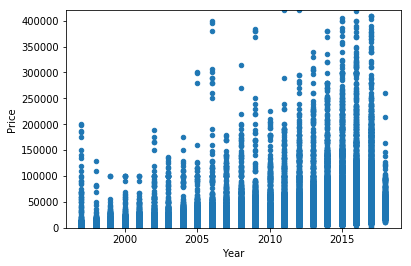

In [0]:
# Bivariate analysis Price / Year
attrib = 'Year'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
data.plot.scatter(x=attrib, y='Price', ylim=(0,420000));

**REMOVING OUTLIERS BY MODEL**

"\nWe can see a huge number of outliers. Now we'll try to get rid of those.\n"

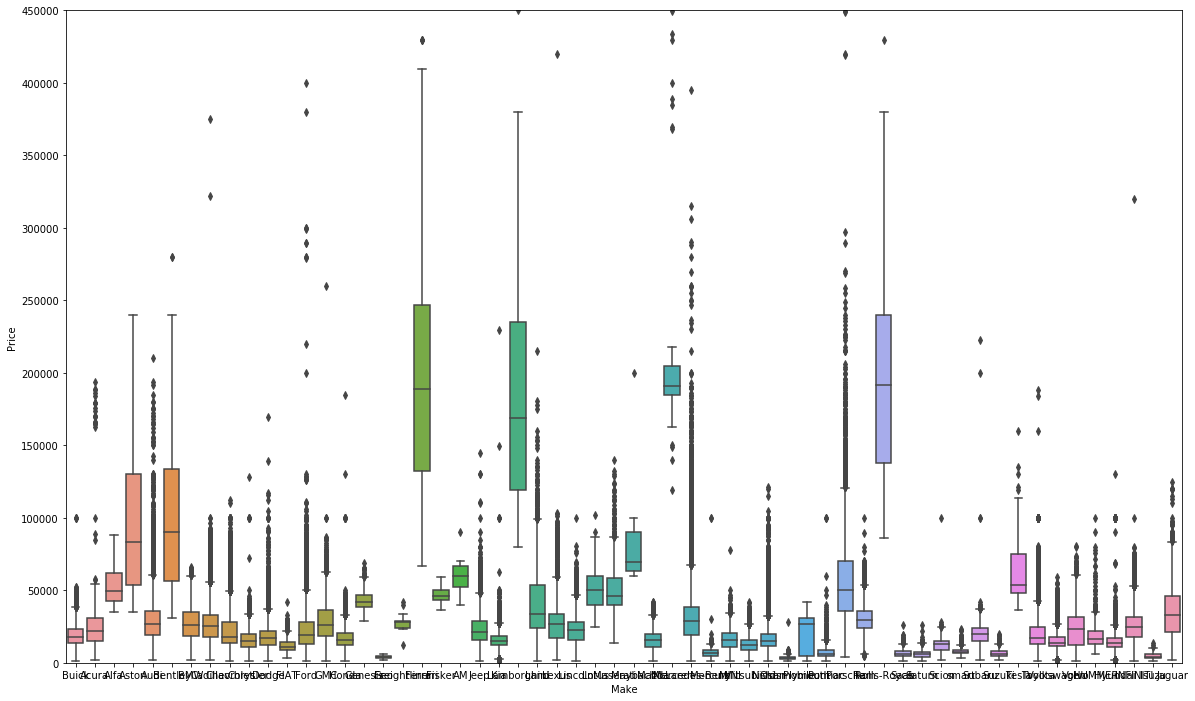

In [8]:
# Box Plot showing car manufacturer / Price range

attrib = 'Make'
data = pd.concat([cars['Price'], cars[attrib]], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x=attrib, y="Price", data=data)
fig.axis(ymin=0, ymax=450000);

"""
We can see a certain number of outliers. Now we'll try to get rid of those.
"""

In [0]:
from numpy import percentile
from functools import partial

category='Model'

models = cars[category].unique()

"""
Here we are taking the values between the 25th and 80th percentile of the 
gaussian curve.
"""
p25 = cars.groupby(by=category)[category,'Price'].agg(lambda x: percentile(x['Price'], 20))
p80 = cars.groupby(by=category)[category,'Price'].agg(lambda x: percentile(x['Price'], 80))

In [0]:
# Now this strategy is applied to the 3k models; it will take up to 10 minutes
# depending on the hardware
models = cars[category].unique()

cars_cleaned = pd.DataFrame()

for i,m in enumerate(models):
    cars_cleaned=cars_cleaned.append(cars[( (cars[category] == m ) & ( (cars["Price"] > p25.Model[m]) & (cars["Price"] <= p80.Model[m])) ) ],ignore_index=True)


In [0]:
cars_cleaned.to_csv('cars_outliers_removed.csv')

### ATTENTION
Alternatively, the cleaned_dataset can be downloaded executing the cell above:

In [9]:
!curl https://raw.githubusercontent.com/francescopisu/Used-car-price-prediction/master/data/cars_outliers_removed.csv --output cars_outliers_removed.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  50.7M      0  0:00:01  0:00:01 --:--:-- 50.7M


In [0]:
# Reading the newly cleaned dataset
cleaned_cars = pd.read_csv("cars_outliers_removed.csv", encoding='latin1', error_bad_lines=False,warn_bad_lines=False)

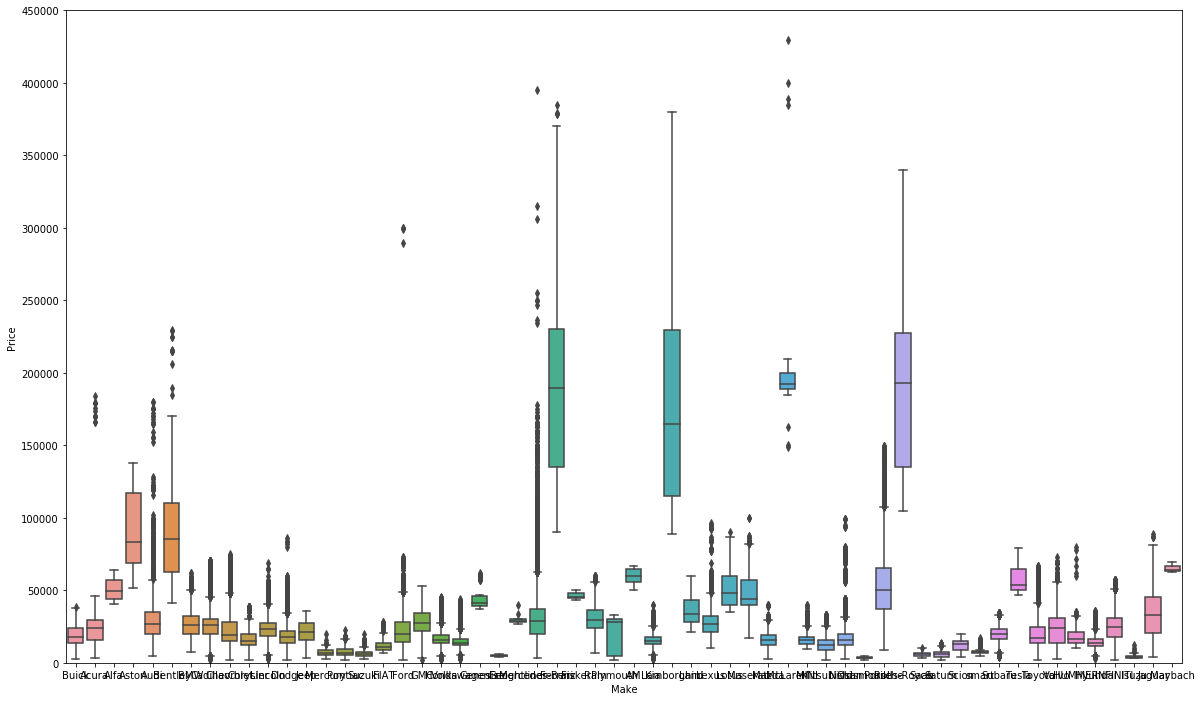

In [11]:
# Box Plot showing car manufacturer / Price range after cleaning

attrib = 'Make'
data = pd.concat([cleaned_cars['Price'], cleaned_cars[attrib]], axis=1)
f, ax = plt.subplots(figsize=(20, 12))
fig = sns.boxplot(x=attrib, y="Price", data=data)
fig.axis(ymin=0, ymax=450000);

In [0]:
print("Too new: %d" % cleaned_cars.loc[cleaned_cars.Year >= 2017].count()['Id'])
print("Too few km: " , cleaned_cars.loc[cleaned_cars.Mileage < 5000].count()['Id'])
print("Too many km: " , cleaned_cars.loc[cleaned_cars.Mileage > 250000].count()['Id'])

Too new: 71946
Too few km:  14055
Too many km:  374


In [0]:
# Drop some unuseful columns with respect to our analysis
cleaned_cars = cleaned_cars.drop(["Id", "State", "Vin", "City"], axis=1)

# Replace the NaN values for categoric attributes
cleaned_cars['Make'].fillna(value='blank', inplace=True)
cleaned_cars['Model'].fillna(value='blank', inplace=True)


# Drop duplicates
cleaned_cars = cleaned_cars.drop_duplicates(["Year", "Mileage", "Price", "Make", "Model"])

# Remove outliers
cleaned_cars = cleaned_cars[
        (cleaned_cars.Year <= 2017) 
      & (cleaned_cars.Year >= 2008)  
      & (cleaned_cars.Mileage >= 5000) 
      & (cleaned_cars.Mileage <= 250000)]

# Remove extra column
cleaned_cars = cleaned_cars.drop(["Unnamed: 0"], axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


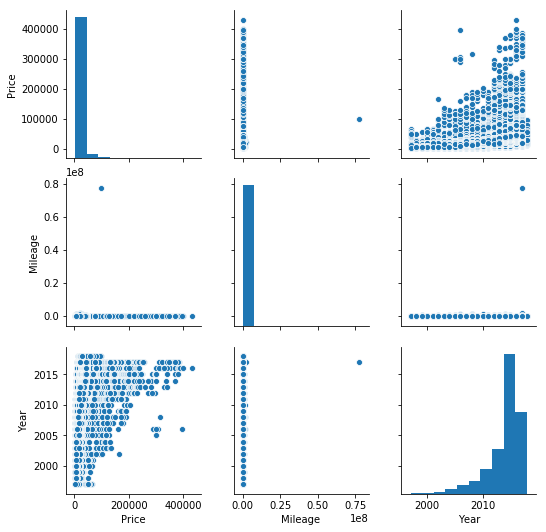

In [12]:
# Scatter plot for numerical features
num_features = ["Price", "Mileage", "Year"]
sns.pairplot(cleaned_cars[num_features], size = 2.5)
plt.show();

# In the Mileage/Price plot we observe that the lesser is the mileage, the higher
# is the price. In the Year/Price plot instead, we observe that the prices
# are somewhat equally distributed between the various years.

In [0]:
cleaned_cars.sample(5)

,Price,Year,Mileage,Make,Model
908528,21250,2016,15209,Kia,SorentoLX
459117,14400,2016,44697,Chevrolet,TraxFWD
511771,30995,2015,28107,Chevrolet,ColoradoCrew
856557,12595,2012,50543,Jeep,Liberty4WD
156319,41000,2017,4759,BMW,X3xDrive28i


### TOWARDS NORMAL DISTRIBUTION OF PRICES


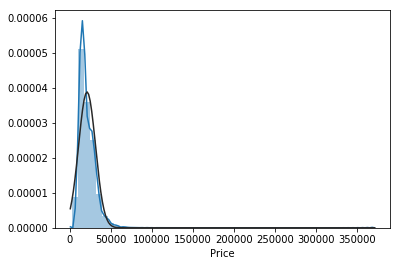

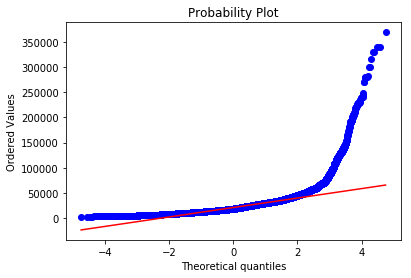

In [0]:
# Distribution of prices
from scipy.stats import norm
from scipy import stats

# Using Histogram and normal probability plot
sns.distplot(cleaned_cars['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(cleaned_cars['Price'], plot=plt)

In [0]:
#applying log transformation
cleaned_cars['Price'] = np.log(cleaned_cars['Price'])

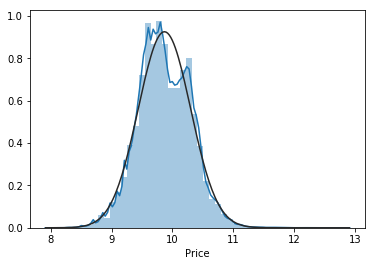

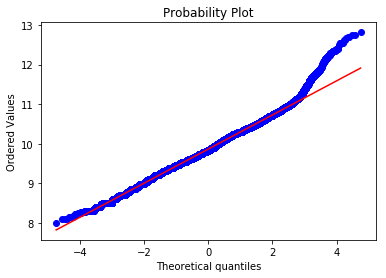

In [0]:
#transformed histogram and normal probability plot
sns.distplot(cleaned_cars['Price'], fit=norm);
fig = plt.figure()
res = stats.probplot(cleaned_cars['Price'], plot=plt)

### LABEL ENCODING

In [0]:
# LABEL ENCODING
features = ['Make', 'Model']
les = {}

for f in features:
  les[f] = preprocessing.LabelEncoder()
  les[f] = les[f].fit(cleaned_cars[f])
  cleaned_cars[f] = les[f].transform(cleaned_cars[f])

### TRAIN / TEST SPLIT

In [0]:
# Splitting the dataset into train and test sets
train_set, test_set = train_test_split(cleaned_cars, test_size = 0.33, random_state = 42)

"""
The Test Set in this case is our Hold-out set that we'll be using later
for final validation
"""

# Separating target labels from the rest
cars_train = train_set.drop("Price", axis=1) #train without target
cars_price_train = train_set["Price"].copy() #target

cars_test  = test_set.drop("Price", axis=1)
cars_price_test = test_set["Price"].copy()


## **TRAINING AND COMPARING MODELS**

**BEST SCORE FUNCTION**

In [0]:
# This function returns the best score achieved by the model over all the cv splits
def best_score(forest, cv):
  best_score = 0
  for i in range(0, cv):
    items = list(map(lambda x: abs(x), forest.cv_results_['split'+str(i)+'_test_score']))
    arr = np.append(best_score, items)
    best_score = max(arr)
  
  return best_score

**BEST PARAMS FUNCTION**

In [0]:
# This functions returns the best combination of parameters, which allows to
# get the best score
def best_params(forest):
  return forest.cv_results_['params'][forest.cv_results_['rank_test_score'][0]-1]

** PERFORMANCE METRIC FUNCTION **

In [0]:
from sklearn.metrics import r2_score

def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true (y_true) and predicted (y_predict) values based on the metric chosen. """
    
    score = r2_score(y_true, y_predict)
    
    # Return the score
    return score

### **LINEAR REGRESSION **

In [0]:
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

import os

# Create a class to select numerical or categorical columns 
# since Scikit-Learn doesn't handle DataFrames yet

class DFSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.feature_names].values

In [0]:
# Setting categorical and numerical attributes
cat_features = ["Make", "Model"]
num_features = list(cars_train.drop(cat_features, axis=1))

# Building the Pipelines for categorical and numerical dataframes
numerical_pipeline = Pipeline([
    ("selector", DFSelector(num_features)),
    ("std_scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("selector", DFSelector(cat_features)),
    ("encoder", OneHotEncoder(sparse=True))
])

# full_pipeline
full_pipeline = FeatureUnion(transformer_list =[
    ("num_pipeline", numerical_pipeline),
    ("cat_pipeline", categorical_pipeline)
])


In [0]:
# Apply the full pipeline
ohe_cars_train = full_pipeline.fit_transform(cars_train) # train set

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
from sklearn.linear_model import LinearRegression

sc = createLocalSparkSession().sparkContext

model = LinearRegression()
parameters = {'fit_intercept':[False], 'normalize':[True,False], 'copy_X':[True, False]}

# Spark parallelized GridSearchCV for hyperparameter tuning
gs = GridSearchCV(sc, estimator=model, param_grid=parameters, cv=3, n_jobs=-1, verbose=1, return_train_score=True)
lin_reg = gs.fit(ohe_cars_train, cars_price_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


In [0]:
# Best CV parameters
bp = best_params(lin_reg)
best_params(lin_reg)

lin_reg_model = LinearRegression(
                              fit_intercept=bp["fit_intercept"],
                              normalize=bp["normalize"],
                              copy_X=bp["copy_X"])
%time lin_reg_model.fit(ohe_cars_train, cars_price_train)

CPU times: user 31.7 s, sys: 20.2 s, total: 51.9 s
Wall time: 26.3 s


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=True)

In [0]:
# LinearRegression score for price prediction
ohe_cars_test = full_pipeline.transform(cars_test)

print("Best Linear Regression parameters:")
print(bp)
print("\nLinear Regressor score without CV on train set: %.3f" % lin_reg_model.score(ohe_cars_train, cars_price_train)) #score on train set
print("Linear Regression score without CV on test set: %.3f" % lin_reg_model.score(ohe_cars_test, cars_price_test)) # score on test set
print("Linear Regression Best score with CV=3: %.3f" % best_score(lin_reg, 3)) # -> best score on test set is high

Best Linear Regression parameters:
{'copy_X': True, 'fit_intercept': False, 'normalize': True}

Linear Regressor score without CV on train set: 0.948
Linear Regression score without CV on test set: 0.947
Linear Regression Best score with CV=3: 0.944


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
# Prediction on whole training set
from sklearn.metrics import mean_squared_error

price_predictions_train = lin_reg_model.predict(ohe_cars_train) #using the whole training set for making prediction with the final model given by the best CV parameters

# Reversing np.log operation
price_predictions_train_normal = np.exp(price_predictions_train)
cars_price_train_normal = np.exp(cars_price_train)

# MSE between target values (i.e known) and predicted values
lin_mse = mean_squared_error(cars_price_train_normal, price_predictions_train_normal)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

2361.2119290102396

In [0]:
print(price_predictions_train_normal[580:590])
print('\n')
print(list(cars_price_train_normal[580:590]))

[16456.00071687 29733.53262715 13460.80153861 26743.80111272
 27811.39591549 14289.70329097 21386.21171622 21667.20994162
 24194.97350527 31464.62616305]


[17900.000000000007, 27785.99999999998, 13998.999999999996, 29995.000000000015, 28699.999999999996, 12947.999999999993, 21992.00000000002, 19995.00000000002, 25204.99999999998, 36000.00000000002]


In [0]:
# Prediction on test set
price_predictions_test = lin_reg_model.predict(ohe_cars_test)

# Reversing np.log operation
price_predictions_test_normal = np.exp(price_predictions_test)
cars_price_test_normal = np.exp(cars_price_test)

final_mse = mean_squared_error(cars_price_test_normal, price_predictions_test_normal)
final_rmse = np.sqrt(final_mse)

final_rmse

2450.7646189902275

In [0]:
print(price_predictions_test_normal[7650:7660]) #predictions on test set
print('\n')
print(list(cars_price_test_normal[7650:7660])) #known values in test set

[19376.86770068 30242.44309789 40573.77690625 30227.88539491
 24661.92343538 21181.8442039  37891.16853105 15743.47212413
 16088.43038458 17888.54157141]


[18300.000000000015, 33879.0, 42499.99999999999, 29000.00000000001, 25991.0, 21987.000000000015, 22496.999999999985, 16796.99999999999, 15999.00000000001, 18200.000000000004]


In [0]:
from sklearn.metrics import r2_score
r2_score(cars_price_test_normal, price_predictions_test_normal, multioutput='variance_weighted') 

0.9438675005845566

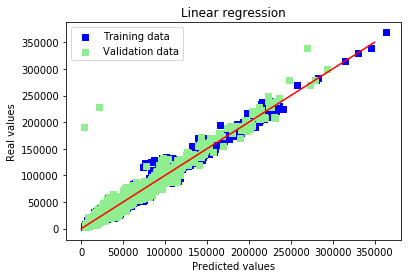

In [0]:
# Plot predictions
plt.scatter(price_predictions_train_normal, np.exp(cars_price_train), c = "blue", marker = "s", label = "Training data")
plt.scatter(price_predictions_test_normal, np.exp(cars_price_test), c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([0, 350000], [0, 350000], c = "red")
plt.show()


In [0]:
# Saving model for type prediction
pickle.dump(lin_reg_model, open("lin_reg_model_final.pkl", "wb"))

In [0]:
# Loading the model for type prediction
lin_reg_model = pickle.load(open("lin_reg_model_final.pkl", 'rb'))

## **DECISION TREE REGRESSOR**

### LEARNING AND COMPLEXITY CURVES

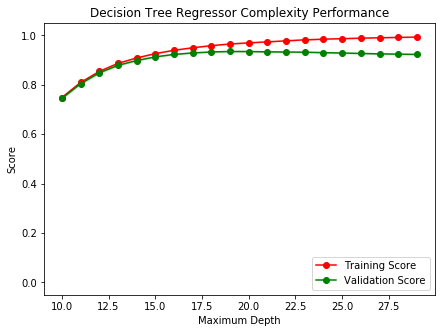

In [0]:
# Produce complexity curve for varying training set sizes and maximum depths
curves.ModelComplexity_DT(cars_train, cars_price_train)

In [0]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer

def DT_SparkizedGridSearchCV(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 42)

    # Create a decision tree regressor object
    regressor = DecisionTreeRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[1, 5, 10, 15, 16, 17]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    sc = createLocalSparkSession().sparkContext
    grid = GridSearchCV(sc, estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    tree_reg = grid.fit(X, y)
    
    # Return grid search output after fittig the data
    return tree_reg

In [0]:
from sklearn.model_selection import ShuffleSplit

# Fit the training data to the model using spark parallelized grid search CV
tree_reg = DT_SparkizedGridSearchCV(cars_train, cars_price_train)

# Takign best parameters
bp = best_params(tree_reg)

# Produce the optimal value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(bp['max_depth']))

Parameter 'max_depth' is 17 for the optimal model.


In [0]:
"""
Due to the limitation of the spark-sklearn library's implementation of
GridSearchCV, best_estimator_ parameter it's not available, so we need to
fit a DecisionTreeRegressor on the best parameters given to us by gridSearchCV
"""
tree_reg_model = DecisionTreeRegressor(
                              max_depth=bp['max_depth'])
%time tree_reg_model.fit(cars_train, cars_price_train)

DecisionTreeRegressor(criterion='mse', max_depth=17, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [0]:
# DecisionTreeRegressor score for price prediction


print("Best Decision Tree Regressor parameters:")
print(bp)
print("\nDecision Tree Regressor score without CV on train set: %.3f" % tree_reg_model.score(cars_train, cars_price_train)) #score on train set
print("Decision Tree Regressor score without CV on test set: %.3f" % tree_reg_model.score(cars_test, cars_price_test)) # score on test set
print("Decision Tree Regressor Best score with CV=10: %.3f" % best_score(tree_reg, 10)) # -> best score on test set is high

Best Decision Tree Regressor parameters:
{'max_depth': 17}

Decision Tree Regressor score without CV on train set: 0.949
Decision Tree Regressor score without CV on test set: 0.930
Decision Tree Regressor Best score with CV=10: 0.931


In [0]:
# Prediction on whole training set
price_predictions_train = tree_reg_model.predict(cars_train) #using the whole training set for making prediction with the final model given by the best CV parameters

# Reversing np.log operation
price_predictions_train_normal = np.exp(price_predictions_train)
cars_price_train_normal = np.exp(cars_price_train)

# MSE between target values (i.e known) and predicted values
lin_mse = mean_squared_error(cars_price_train_normal, price_predictions_train_normal)
lin_rmse = np.sqrt(lin_mse)
lin_rmse # is higher than RMSE of linear regression, in fact the best score is smaller (0.58 vs 0.89)

2438.8145008205174

In [0]:
print(price_predictions_train_normal[1670:1680])
print('\n')
print(list(cars_price_train_normal[1670:1680]))

[46410.9161647  15140.92013303 23604.93919515 26968.62968701
 25458.8409949  13832.74746199 62580.15299687 12876.00829602
 22918.37949149 16002.9971716 ]


[40997.0, 15500.00000000001, 23994.99999999999, 28575.999999999978, 28902.999999999993, 12399.999999999996, 64993.99999999994, 11989.99999999999, 22994.999999999996, 14998.000000000002]


In [0]:
# Prediction on test set
price_predictions_test = tree_reg_model.predict(cars_test)

# reversing np.log operation
price_predictions_test_normal = np.exp(price_predictions_test)
cars_price_test_normal = np.exp(cars_price_test)

final_mse = mean_squared_error(cars_price_test_normal, price_predictions_test_normal)
final_rmse = np.sqrt(final_mse)

final_rmse

3080.1293801220186

In [0]:
print(price_predictions_test_normal[1939:1949]) #predictions on test set
print('\n')
print(list(cars_price_test_normal[1939:1949])) #known values in test set

[15816.97837917 26968.62968701 21798.24986954 14677.83327566
 17703.06484765  8700.         31594.53691537 15816.97837917
 22043.31240188 12551.5251707 ]


[15960.000000000011, 26975.000000000004, 21794.99999999998, 13221.000000000005, 21932.0, 9499.999999999995, 31494.99999999998, 14899.999999999995, 20887.000000000015, 11613.999999999995]


In [0]:
from sklearn.metrics import r2_score
r2_score(cars_price_test_normal, price_predictions_test_normal, multioutput='variance_weighted') 

0.9113356376021451

**PREDIZIONE PREZZO MACCHINA**

In [0]:
model = les['Model'].transform(['Maxima3.5'])
brand = les['Make'].transform(['Nissan'])

year = 2016
mileage = 21000

car = [[ year, mileage, brand[0], model[0]]]

In [0]:
predicted_price = tree_reg_model.predict(car)
print(np.exp(predicted_price))

[21146.63899531]


In [0]:
# Saving model for type prediction
pickle.dump(tree_reg_model, open("tree_reg_model_final.pkl", "wb"))

In [0]:
# Loading the model for type prediction
tree_reg_model = pickle.load(open("tree_reg_model_final.pkl", 'rb'))

## **RANDOM FOREST REGRESSOR**

### LEARNING AND COMPLEXITY CURVES

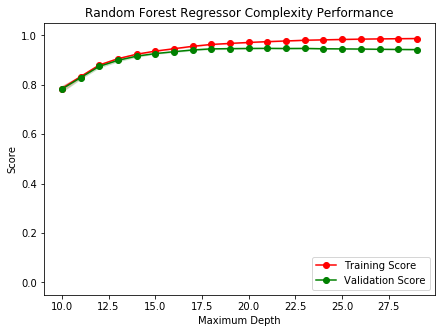

In [0]:
# Produce complexity curve for varying training set sizes and maximum depths
curves.ModelComplexity_RF(cars_train, cars_price_train)

### Model Training

In [0]:
# Import 'make_scorer', 'DecisionTreeRegressor', and 'GridSearchCV'
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer

def RF_SparkizedGridSearchCV(X, y):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 42)

    # Create a decision tree regressor object
    regressor = RandomForestRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    params = {'max_depth':[16, 17, 18]}

    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search cv object --> GridSearchCV()
    sc = createLocalSparkSession().sparkContext
    grid = GridSearchCV(sc, estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    # Fit the grid search object to the data to compute the optimal model
    tree_reg = grid.fit(X, y)
    
    # Return the best parameters after fitting the data
    return tree_reg

In [0]:
from sklearn.model_selection import ShuffleSplit

# Fit the training data to the model using spark parallelized grid search CV
forest_reg = RF_SparkizedGridSearchCV(cars_train, cars_price_train)

# Takign best parameters
bp = best_params(forest_reg)

# Produce the optimal value for 'max_depth'
print("Parameter 'max_depth' is {} for the optimal model.".format(bp['max_depth']))

Parameter 'max_depth' is 18 for the optimal model.


In [0]:
# Fitting the forest

forest_reg_model = RandomForestRegressor(
                              max_depth=bp['max_depth']
                                 
)

%time forest_reg_model.fit(cars_train, cars_price_train)

CPU times: user 9.31 s, sys: 9.99 ms, total: 9.32 s
Wall time: 9.33 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=18,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [0]:
# RandomForestRegressor score for price prediction

print(bp)
print("\nRandom Forest Regressor score without CV on train set: %.3f" % forest_reg_model.score(cars_train, cars_price_train)) #score on train set
print("Random Forest Regressor score without CV on test set: %.3f" % forest_reg_model.score(cars_test, cars_price_test)) #score on test set
print("Random Forest Regressor Best score with CV=4: %.3f" % best_score(forest_reg, 4)) # -> best score on test set is high

{'max_depth': 18}

Random Forest Regressor score without CV on train set: 0.962
Random Forest Regressor score without CV on test set: 0.946
Random Forest Regressor Best score with CV=4: 0.947


In [0]:
# Prediction on whole training set
price_predictions_train = forest_reg_model.predict(cars_train) #using the whole training set for making prediction with the final model given by the best CV parameters

# Reversing np.log operation
price_predictions_train_normal = np.exp(price_predictions_train)
cars_price_train_normal = np.exp(cars_price_train)

# MSE between target values (i.e known) and predicted values
lin_mse = mean_squared_error(cars_price_train_normal, price_predictions_train_normal)
lin_rmse = np.sqrt(lin_mse)
lin_rmse 

2234.189281837711

In [0]:
print(price_predictions_train_normal[25670:25680])
print('\n')
print(list(cars_price_train_normal[25670:25680]))

[14210.39220435 19687.4955406  16263.91196879 14844.26045329
 38370.34926288 11985.77678189 17131.08883729 13991.38861044
 19393.22669554 28448.35441068]


[15275.00000000001, 20495.99999999998, 15190.00000000001, 16995.00000000001, 37844.99999999997, 13499.999999999996, 17994.999999999993, 12500.0, 17499.00000000001, 24491.000000000007]


In [0]:
# Prediction on test set
price_predictions_test = forest_reg_model.predict(cars_test)

# Reversing np.log operation
price_predictions_test_normal = np.exp(price_predictions_test)
cars_price_test_normal = np.exp(cars_price_test)

final_mse = mean_squared_error(cars_price_test_normal, price_predictions_test_normal)
final_rmse = np.sqrt(final_mse)

final_rmse

2786.99539824276

In [0]:
print(price_predictions_test_normal[1870:1880]) #predictions on test set
print('\n')
print(list(cars_price_test_normal[1870:1880])) #known values in test set

[64124.97760801 15396.78939442 12261.62101611 24442.99733112
 26449.74008966 19765.33370631 29406.69688323 17226.04896769
 16400.51449343 15434.86717471]


[58950.00000000004, 13997.999999999995, 10775.00000000001, 22999.999999999993, 28854.99999999999, 17585.000000000007, 28921.00000000002, 17294.0, 18991.000000000015, 16162.000000000004]


In [0]:
# r2 score between hold out prices and predicted prices
r2_score(cars_price_test_normal, price_predictions_test_normal, multioutput='variance_weighted') 

0.9177127473518794

In [0]:
# Saving model for type prediction
pickle.dump(forest_reg_model, open("forest_reg_model_final.pkl", "wb"))

In [0]:
# Loading the model for type prediction
forest_reg_model = pickle.load(open("forest_reg_model_final.pkl", 'rb'))

## **CROSS VALIDATION**

In [0]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

### LINEAR REGRESSION

In [0]:
# Cross val score on training set, although we already used GridSearchCV 

train_scores = cross_val_score(lin_reg_model, ohe_cars_train, np.exp(cars_price_train),
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-train_scores)

display_scores(tree_rmse_scores)

Scores: [2511.16394403 2507.64383783 2503.00193271 2570.69792508 2837.54813843
 2508.55149952 2665.38495527 2564.91369963 2658.98435517 2585.36184674]
Mean: 2591.3252134411264
Standard deviation: 99.9639133963208


In [0]:
train_scores = cross_val_score(lin_reg_model, ohe_cars_train, np.exp(cars_price_train),
                          cv=10)

display_scores(train_scores)

Scores: [0.94209893 0.93955344 0.94063465 0.9385359  0.92148046 0.93777246
 0.93264279 0.93404961 0.93651303 0.93434958]
Mean: 0.9357630846009126
Standard deviation: 0.0055605212885602535


### DECISION TREE

In [0]:
# Cross val score on training set

train_scores = cross_val_score(tree_reg_model, cars_train, np.exp(cars_price_train),
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-train_scores)

display_scores(tree_rmse_scores)

Scores: [2697.16985395 2895.43681422 2876.56158717 3429.01511938 3259.6287445
 2809.82393056 3032.75544851 2950.64476464 3517.11013286 2907.55408647]
Mean: 3037.5700482258812
Standard deviation: 259.0072400196213


In [0]:
train_scores = cross_val_score(tree_reg_model, cars_train, np.exp(cars_price_train),
                          cv=10)

display_scores(train_scores)

Scores: [0.93256765 0.91334529 0.92279967 0.89073333 0.90048667 0.88826049
 0.89880155 0.91453717 0.89087636 0.91993826]
Mean: 0.90723464331813
Standard deviation: 0.01467186890271162


###RANDOM FOREST

In [0]:
from sklearn.model_selection import KFold

# Cross val score on training set, although we already used grid search CV
train_scores = cross_val_score(forest_reg_model, cars_train, np.exp(cars_price_train),
                         scoring="neg_mean_squared_error", cv=KFold(10, shuffle=True))
forest_rmse_scores = np.sqrt(-train_scores)

display_scores(forest_rmse_scores)

Scores: [2561.09317022 2369.82409027 2566.44861831 2951.1736042  2727.2739599
 2477.14086725 2671.18929575 2836.8378967  2633.51208581 2850.18516537]
Mean: 2664.467875377254
Standard deviation: 171.3333085374168


In [0]:
train_scores = cross_val_score(forest_reg_model, cars_train, np.exp(cars_price_train),
                          cv=5)

display_scores(train_scores)

Scores: [0.93386328 0.93225079 0.92686771 0.93629736 0.91087319]
Mean: 0.9280304661927514
Standard deviation: 0.009120291835010862


## **PREDICTIONS ON FINAL MODEL AND CONCLUSIONS**

In [0]:
final_model = forest_reg_model

**FEATURE IMPORTANCE**

CPU times: user 3min 28s, sys: 151 ms, total: 3min 28s
Wall time: 3min 28s


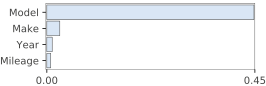

In [0]:
# Feature importance computed with cross validation
from rfpimp import cv_importances, plot_importances
%time I = cv_importances(final_model, cars_train, np.exp(cars_price_train), k=5)
plot_importances(I)

In [0]:
# Prediction on the hold out test set
final_predictions = final_model.predict(cars_test)

final_mse = mean_squared_error(np.exp(cars_price_test), np.exp(final_predictions))

final_rmse = np.sqrt(final_mse)

In [0]:
print("Test RMSE: %f " % final_rmse)
print("Score on held-out Test Set: %f " % final_model.score(cars_test, cars_price_test))
print("R2 Score: %f" % r2_score(np.exp(cars_price_test), np.exp(final_predictions)))

Test RMSE: 2747.748109 
Score on held-out Test Set: 0.946120 
R2 Score: 0.929439


In [0]:
# Cross validation on the entire dataset, since we are good with out final model

features = cleaned_cars.drop(['Price'], axis=1)
prices = cleaned_cars['Price'].copy()

final_rmses= cross_val_score(final_model, features, np.exp(prices),
                          scoring="neg_mean_squared_error", cv=KFold(10, shuffle=True))

final_rmse_scores = np.sqrt(-final_rmses)
display_scores(final_rmse_scores)

Scores: [2727.38026574 2520.80068608 2380.93656955 2344.55974071 2417.68464464
 2563.77339475 2448.26679128 2609.54453714 2560.65092553 2568.92798704]
Mean: 2514.252554245856
Standard deviation: 110.62986563980498


In [0]:
final_scores = cross_val_score(tree_reg_model, features, np.exp(prices),
                          cv=KFold(10, shuffle=True))

display_scores(final_scores)

Scores: [0.92363687 0.92515218 0.91352811 0.92441993 0.9229376  0.91636733
 0.92000227 0.92042841 0.92807571 0.92346807]
Mean: 0.9218016488414259
Standard deviation: 0.004098628221564339
